# Spatial Processing Benchmarks in Python
### Krzysztof Dyba

In [1]:
# display multiple outputs from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# required libraries
# import os, zipfile, timeit, random, statistics, urllib.request
# import rasterio, rasterio.plot, rasterio.mask, rasterio.enums
# import shapely.geometry, geopandas

## Introduction

The primary way to perform a benchmark in Python is to use the `Timer` class from `{timeit}` library.
You can view the documentation interactively in Jupyter Notebook by using the question mark "?" before the function or by using the dedicated `help()` function.
However, first we need to import the library.

In [3]:
import timeit
?timeit.Timer

The use of this function is a bit more complicated than in R.
Let's test it as before with the example of sampling numbers with replacement.
For this purpose, we can use `choices()` function from the `{random}` library.

In [4]:
import random
random.choices(range(1, 100), k = 5)

[67, 76, 52, 34, 58]

Now we will use the `repeat()` function which performs the benchmark multiple times.
We need to define:
  1. expression as text
  2. global namespace
  3. number of executions of the expression
  4. number of repetitions of the test
The result will be a list with timings.

In [5]:
n = 1_000_000
t = timeit.repeat("random.choices(range(1, 100), k = n)",
                  globals = globals(), number = 1, repeat = 5)
t

[0.15178749999999996,
 0.1285543,
 0.1199066000000002,
 0.12518530000000005,
 0.11753309999999972]

From these values, we can calculate the basic statistics (like mean and standard deviation).
Statistical functions can be found in the `{statistics}` library.

In [6]:
import statistics
round(statistics.mean(t), 2)
round(statistics.stdev(t), 4)

0.13

0.0137

For Jupyter Notebooks, there is an alternative easier way.
We can use the `timeit()` function with a percent symbol:
  - `%timeit` to benchmark a single function
  - `%%timeit` to benchmark an entire cell

In [7]:
%timeit -r 5 -n 1 random.choices(range(1, 100), k = n)

120 ms ± 3 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [8]:
%%timeit -r 5 -n 1
random.choices(range(1, 100), k = n)

120 ms ± 1.87 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


**Exercise**

Compare computing the mean value of the list using `statistics.mean()` and `sum() / len()` functions.

## Part I: Raster Data

### Data Source

For testing, we will use exactly the same raster as in the previous part.
For more information, see the [R notebook](https://kadyb.github.io/OGH2022/R.html#Data_Source).

In [9]:
import os
import zipfile
import urllib.request

url = "https://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_39_02.zip"

if not os.path.isdir("data"):
    os.mkdir("data")
    urllib.request.urlretrieve(url, "data/srtm.zip")
    with zipfile.ZipFile("data/srtm.zip","r") as zip_ref:
        zip_ref.extractall("data") # ~70 MB tif

### Benchmarks

In [10]:
import rasterio

#### Data Loading

From a user perspective, Python requires more programming skills.
Consequently, you will have to write more lines of code and the workflow will eventually be more complex.
Loading data in `{rasterio}` consists of several steps:
  1. Open a connection to a file.
  2. Load raster metadata.
  3. Load values into {numpy} array.
  4. Close the connection to the file.
When the dataset consists of many files with the same spatial extent (e.g. satellite scene), then we have to iterate over all the files.

In [11]:
# open connection to file
raster = rasterio.open("data/srtm_39_02.tif")

# load all metadata
metadata = raster.meta

# you can also call individual attributes
# raster.bounds
# raster.res
# raster.shape

# load values
# if there are NAs in raster, then use the `masked = True` argument
matrix = raster.read(masked = True)

# close connection
raster.close()

Let's print the metadata.
For a description of affine transformation parameters, see this [blogpost](https://www.perrygeo.com/python-affine-transforms.html).

In [12]:
print(metadata)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 6000, 'height': 6000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, 10.0,
       0.0, -0.0008333333333333334, 55.0)}


Let's also print the small part of matrix.
Note that indexing in Python starts at 0!

In [13]:
matrix[0, 0:3, 0:3] # check another extent yourself

masked_array(
  data=[[--, --, --],
        [--, --, --],
        [--, --, --]],
  mask=[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],
  fill_value=-32768,
  dtype=int16)

Missing values (NA) are marked with the value -32768, and the datatype is int16.
We can also check how much space this object takes up in memory using `.nbytes` method.

In [14]:
# return result in MB
matrix.nbytes / 1024**2

68.66455078125

As you can see, the structure of raster data in `{rasterio}` looks quite different than in R.
Notice also that the stored object takes up less space.
Nevertheless, Python also uses the float (double) type for calculations.

After the data is loaded, we can visualize it.
The easiest way to do this is to use the `show()` function from the `plot` module.
By default, the matrix coordinates are stored in the row/column system.
To convert them to geographic coordinates you need to use the affine transformation parameters previously stored in the `transform` slot of the `metadata` object.

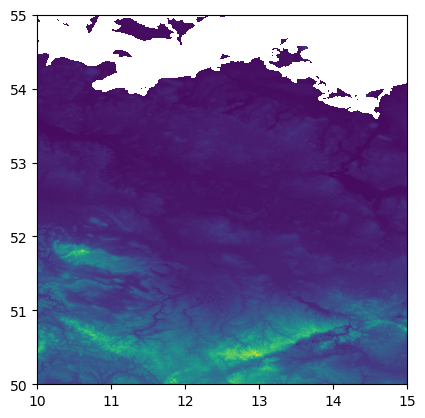

<AxesSubplot:>

In [15]:
from rasterio.plot import show
show(matrix, transform = metadata["transform"])

Now let's perform the benchmark.

In [16]:
%%timeit -r 5 -n 1
raster = rasterio.open("data/srtm_39_02.tif")
matrix = raster.read(masked = True)
metadata = raster.meta
raster.close()

158 ms ± 13.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


#### Cropping

To crop the raster to the extent, we need to import the `mask` module from `{rasterio}` and use the `{shapely}` library to handle the geometry.
The extent can be defined using the `ext()` function and four coordinates.
In the next step, use the `mask()` function, which takes as arguments a connection to the file, the geometry as a list, and the `crop = True` argument.

In [17]:
import rasterio.mask
from shapely.geometry import box

ext = box(11, 14, 51, 53) # minx, miny, maxx, maxy
raster = rasterio.open("data/srtm_39_02.tif")
crop = rasterio.mask.mask(raster, [ext], crop = True)
raster.close()

The result is a tuple consisting of a numpy matrix and an object with affine transformation parameters.
Let's visualize the matrix as we did before (we have to select index 0).

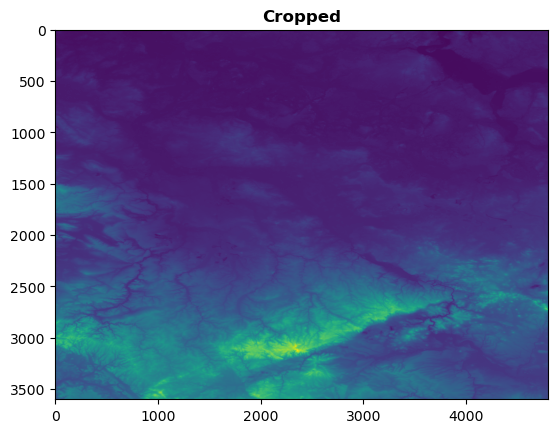

<AxesSubplot:title={'center':'Cropped'}>

In [18]:
show(crop[0], title = "Cropped")

Finally, the benchmark:

In [19]:
raster = rasterio.open("data/srtm_39_02.tif")
%timeit -r 5 -n 1 rasterio.mask.mask(raster, [ext], crop = True)
raster.close()

144 ms ± 11.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


#### Downsampling

Resampling in `{rasterio}` can be done at the data loading stage.
We need to define the target number of rows and columns (while in `{terra}` and `{stars}` we defined the target resolution).
All available resampling methods can be found [here](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling), but we will use "average" as before.
After creating new raster at a lower resolution, we need to update the pixel size in the object with affine transformation parameters ourselves.

In [20]:
from rasterio.enums import Resampling

# this is the resolution equivalent of 0.01 degrees in pixels
height_dest = 500
width_dest = 500

raster = rasterio.open("data/srtm_39_02.tif")
metadata = raster.meta

# resample
raster_small = raster.read(
    out_shape = (raster.count, height_dest, width_dest),
    resampling = Resampling.average,
    masked = True
)

# update resolution
new_transform = raster.transform * raster.transform.scale(
    (raster.width / raster_small.shape[-1]),
    (raster.height / raster_small.shape[-2])
)

raster.close()

Let's see the size of our raster after resampling.

In [21]:
raster_small.shape

(1, 500, 500)

Pixel size before and after resampling:

In [22]:
metadata["transform"]
new_transform

Affine(0.0008333333333333334, 0.0, 10.0,
       0.0, -0.0008333333333333334, 55.0)

Affine(0.01, 0.0, 10.0,
       0.0, -0.01, 55.0)

Benchmark:

In [23]:
%%timeit -r 5 -n 1
raster = rasterio.open("data/srtm_39_02.tif")
raster_small = raster.read(
    out_shape = (raster.count, height_dest, width_dest),
    resampling = Resampling.average,
    masked = True
)
new_transform = raster.transform * raster.transform.scale(
    (raster.width / raster_small.shape[-1]),
    (raster.height / raster_small.shape[-2])
)
raster.close()

399 ms ± 53.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


#### Downsampling

Prepare a task in which you check the performance of pixel classification using the height condition.
For example, all pixels above the threshold of 200 m will become 1, and all pixels below 0.
See also section [Indexing on ndarrays](https://numpy.org/doc/stable/user/basics.indexing.html) in the `{numpy}` documentation.

## Part I: Vector Data

In [24]:
import geopandas
import random

### Data Source

In R, we used a random seed to make the generated data the same every time.
Similarly in Python, randomness can be controlled using the `random.seed()` function.
However, setting the same seed in both environments will not result in identical data (but there are [ways](https://github.com/GjjvdBurg/SyncRNG) to solve it).
For this reason, we will use the data we [created](https://kadyb.github.io/OGH2022/R.html#Data_Source10) earlier in R -- to compare exactly the same things.
Nevertheless, this is what a Python implementation could look like (but it's not the only way):

In [25]:
%%capture --no-stdout

n = 200000
x, y = [], [] # create empty lists

random.seed(123)
for i in range(n):
    x.append(random.uniform(10, 15))
    y.append(random.uniform(50, 55))

pts = geopandas.GeoSeries.from_xy(x, y, crs = "EPSG:4326")
pts = pts.to_crs(3857)
pts.to_file("data/points2.gpkg")

### Benchmarks

#### Data Loading

The `read_file()` function is used to load the data in `{geopandas}`.
After loading, we can display the information, we just need to call the object.
However, to display detailed information about CRS and extent, we have to use `crs` and `total_bounds` methods.

In [26]:
vector = geopandas.read_file("data/points.gpkg")
vector[0:5]
vector.crs
vector.total_bounds # minx, miny, maxx, maxy

,geometry
0,POINT (1273259.823 6987154.174)
1,POINT (1551963.539 6909107.966)
2,POINT (1340830.421 7329358.608)
3,POINT (1604680.147 7173921.049)
4,POINT (1636656.604 6869424.855)


<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

array([1113196.83718289, 6446280.00609634, 1669792.31861506,
       7361860.10625515])

Let's do the benchmark.

In [27]:
%timeit -r 5 -n 1 geopandas.read_file("data/points.gpkg")

3.01 s ± 101 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


#### Buffers

Creating buffers in `{geopandas}` looks very similar to `{sf}` and `{terra}`.
We also need to define the width and the number of segments (`resolution` argument).

In [28]:
buffer = vector.buffer(50000, resolution = 5)
buffer[0:5]

0    POLYGON ((1323259.823 6987154.174, 1320812.649...
1    POLYGON ((1601963.539 6909107.966, 1599516.365...
2    POLYGON ((1390830.421 7329358.608, 1388383.247...
3    POLYGON ((1654680.147 7173921.049, 1652232.973...
4    POLYGON ((1686656.604 6869424.855, 1684209.430...
dtype: geometry

Then we can visualize some of the output in a simple way (n = 100).
Note that the first plot must be saved as the base to the new variable.

<AxesSubplot:>

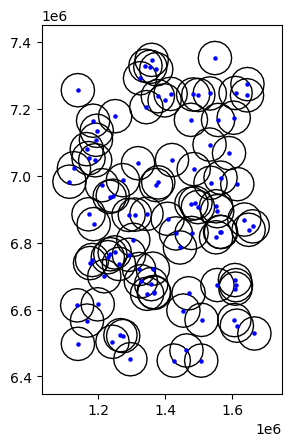

In [29]:
base = buffer[0:100].plot(facecolor = "none")
vector[0:100].plot(ax = base, markersize = 5, color = "blue")

Let's check the performance of this operation.

In [30]:
%timeit -r 5 -n 1 vector.buffer(50000, resolution = 5)

2.22 s ± 40.3 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


*This test is an example where `{geopandas}` is more than twice as fast as the counterparts in `{sf}` and `{terra}`.*

#### Distance

The function for calculating the [distance](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html) between points works a little differently than in previous packages.
If we provide the same two lists of geometries, the distance will be 0 everywhere.

In [31]:
vector[0:5].distance(vector[0:5])

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

The solution to this situation can be to write a standard loop that will calculate the distance between all the points (1-1, 1-2, 1-3, ..., etc.).
However, a better solution would be to use the function vectorization very often used in R (see `*apply()` family).

In [32]:
v = vector[0:3000] # sample data
dist = v.geometry.apply(lambda f: v.distance(f))
dist.iloc[0:5, 0:5]

,0,1,2,3,4
0,0.000000,289425.243896,348811.783881,380422.523368,381991.377803
1,289425.243896,0.000000,470306.066216,270009.276894,93528.950228
2,348811.783881,470306.066216,0.000000,306231.142304,546856.643188
3,380422.523368,270009.276894,306231.142304,0.000000,306170.583493
4,381991.377803,93528.950228,546856.643188,306170.583493,0.000000


The last benchmark.

In [33]:
%timeit -r 5 -n 1 v.geometry.apply(lambda f: v.distance(f))

3.9 s ± 110 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


#### Excercise

Write and test a function that returns raster values for a point layer.
The [rasterio.sample](https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html) module will be helpful for this (note that a list of coordinates is expected, not geometries).

In [34]:
pts = geopandas.read_file("data/points.gpkg")
pts = pts.to_crs(4326)
# convert GeoDataFrame to list of coordinates
xy = [(x, y) for x, y in zip(pts["geometry"].x , pts["geometry"].y)]

raster = rasterio.open("data/srtm_39_02.tif")
pts["value"] = [i[0] for i in raster.sample(xy)]
raster.close()